In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import torch

# Mutag

In [4]:
dataset = MUTAGDataset(seed=12345)

In [7]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=3)
model.load_state_dict(torch.load('ckpts/mutag.pt'))

<All keys matched successfully>

In [8]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.9202127456665039,
 'cm': array([[ 55,   8],
        [  7, 118]]),
 'f1': {'nonmutagen': 0.8799999952316284, 'mutagen': 0.9402390718460083}}

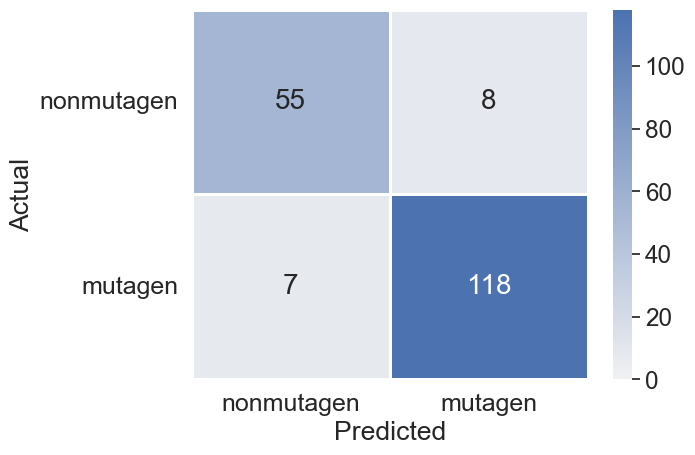

In [10]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [11]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
trainer = {}
sampler = {}

# Mutagen

In [126]:
cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=len(dataset.NODE_CLS),
        temperature=0.15,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=50),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=4),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [127]:
cls_idx = 1
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=30,
    w_budget_init=0.5,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=32
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=18 m=21
logits=[-67.50606536865234, 67.3138427734375]
probs=[0.0, 1.0]


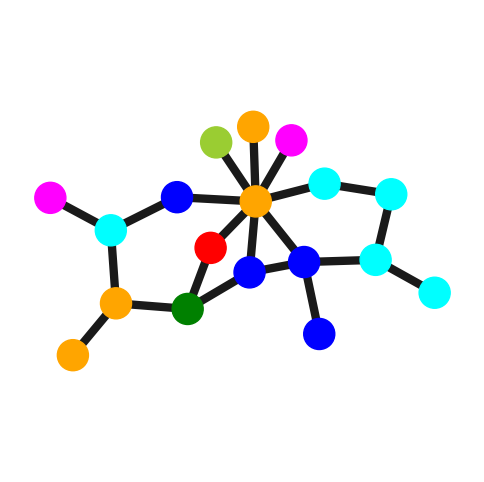

In [128]:
trainer[1].evaluate(threshold=0.5, show=True)

# Non-Mutagen

In [138]:
cls_idx = 0
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=len(dataset.NODE_CLS),
        temperature=0.15,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
)

In [139]:
cls_idx = 0
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=30,
    w_budget_init=0.5,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=32
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=18 m=22
logits=[116.56851959228516, -130.42066955566406]
probs=[1.0, 0.0]


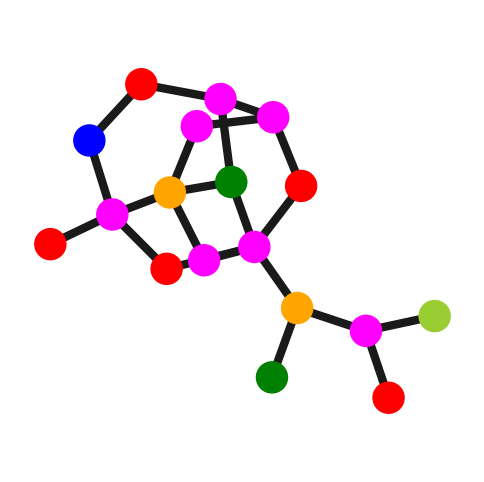

In [140]:
trainer[0].evaluate(threshold=0.5, show=True)